In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
%matplotlib inline

In [3]:
from matplotlib import pyplot as plt
import numpy as np
import random

import torch
from torch.utils.data import DataLoader
import torch.nn as nn
import torch.nn.functional as F

from torchvision.datasets import CIFAR10
from torchvision import transforms

from torchsummary import summary
from tqdm import tqdm

# Parser DataSet

In [4]:
import time
import numpy as np

In [5]:
from PIL import Image

In [6]:
path = './IMagenet/tiny-imagenet-200/'

def get_id_dictionary():
    id_dict = {}
    for i, line in enumerate(open( path + 'wnids.txt', 'r')):
        id_dict[line.replace('\n', '')] = i
    return id_dict

def get_class_to_id_dict():
    id_dict = get_id_dictionary()
    all_classes = {}
    result = {}
    for i, line in enumerate(open( path + 'words.txt', 'r')):
        n_id, word = line.split('\t')[:2]
        all_classes[n_id] = word
    for key, value in id_dict.items():
        result[value] = (key, all_classes[key])      
    return result

def get_data(id_dict):
    print('starting loading data')
    train_data, test_data = [], []
    train_labels, test_labels = [], []
    t = time.time()
    for key, value in id_dict.items():
        train_data += [np.array(Image.open(path + 'train/{}/images/{}_{}.JPEG'.format(key, key, str(i))).convert('RGB')) for i in range(500)]
        train_labels_ = np.array([[0]*200]*500)
        train_labels_[:, value] = 1
        train_labels += train_labels_.tolist()

    for line in open( path + 'val/val_annotations.txt'):
        img_name, class_id = line.split('\t')[:2]
        test_data.append(np.array(Image.open(path + 'val/images/{}'.format(img_name)).convert('RGB')))
        test_labels_ = np.array([[0]*200])
        test_labels_[0, id_dict[class_id]] = 1
        test_labels += test_labels_.tolist()

    print('finished loading data, in {} seconds'.format(time.time() - t))
    return np.array(train_data), np.array(train_labels), np.array(test_data), np.array(test_labels)
  
train_data, train_labels, test_data, test_labels = get_data(get_id_dictionary())

print( "train data shape: ",  train_data.shape )
print( "train label shape: ", train_labels.shape )
print( "test data shape: ",   test_data.shape )
print( "test_labels.shape: ", test_labels.shape )

starting loading data
finished loading data, in 25.957706928253174 seconds
train data shape:  (100000, 64, 64, 3)
train label shape:  (100000, 200)
test data shape:  (10000, 64, 64, 3)
test_labels.shape:  (10000, 200)


In [7]:
test_labels_1 = []
for i in range(len(test_labels)):
    test_labels_1.append(np.argmax(test_labels[i]))

In [8]:
test_labels = np.array(test_labels_1)

In [9]:
test_labels.shape

(10000,)

In [10]:
train_labels_1 = []
for i in range(len(train_labels)):
    train_labels_1.append(np.argmax(train_labels[i]))

In [11]:
train_labels = np.array(train_labels_1)

In [12]:
train_labels.shape

(100000,)

In [13]:
dataset_list = [(train_data[i], train_labels[i]) for i in range(train_data.shape[0])]

In [14]:
for i in range(test_data.shape[0]):
    dataset_list.append((test_data[i], test_labels[i]))

In [15]:
random.seed(1)

In [16]:
random.shuffle(dataset_list)

In [17]:
total_count = len(dataset_list)

In [18]:
n = int(total_count * 0.7)

In [19]:
n

77000

In [20]:
train_set = dataset_list[:n]

In [45]:
len(train_set)

77000

In [21]:
pass

In [23]:
test_set = dataset_list[n:]

In [25]:
import os

In [46]:
for i, (img, label) in enumerate(train_set):
    img = Image.fromarray(img)
    img.save('./data/train/' + str(label) + '/train_' + str(i) +'.jpg')

In [42]:
import glob

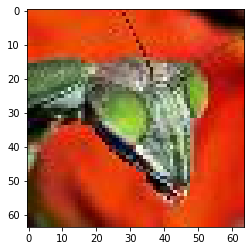

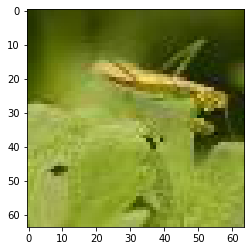

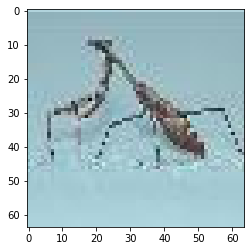

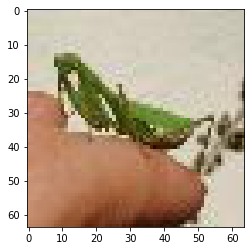

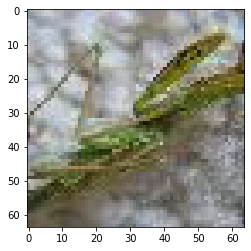

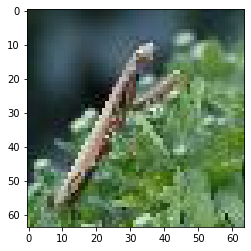

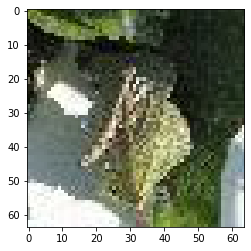

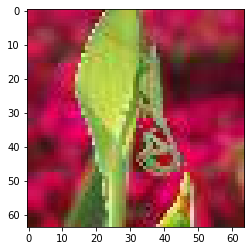

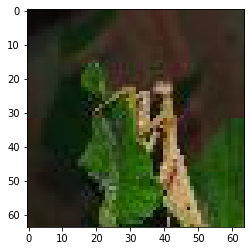

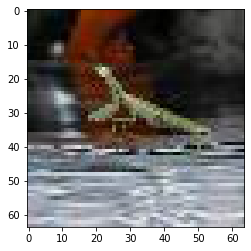

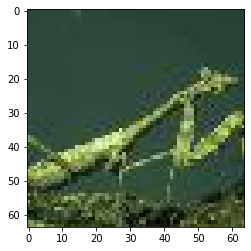

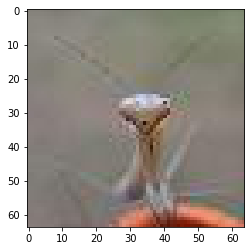

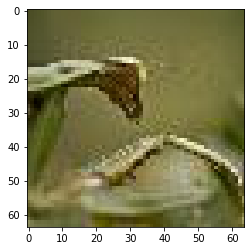

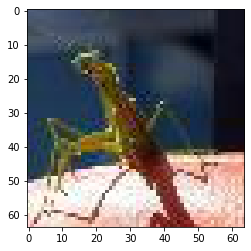

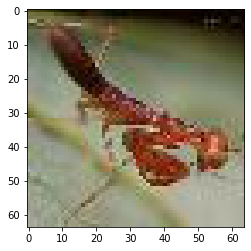

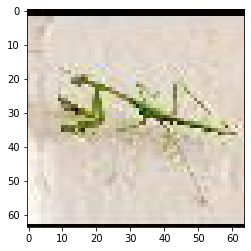

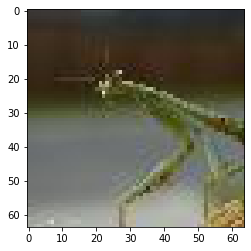

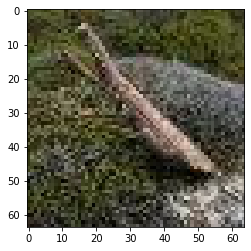

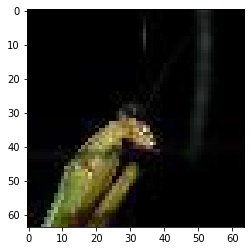

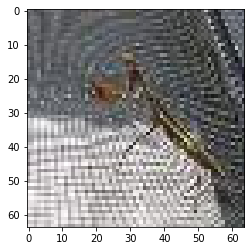

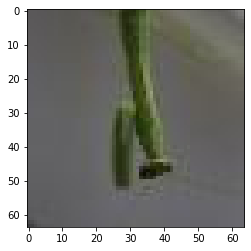

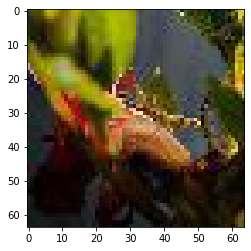

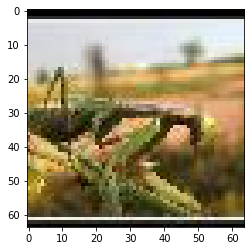

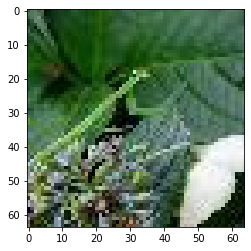

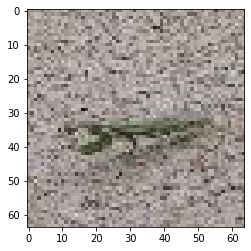

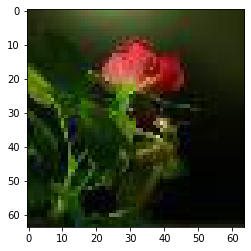

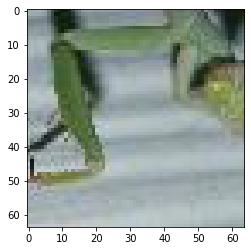

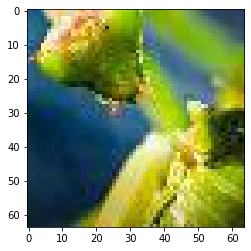

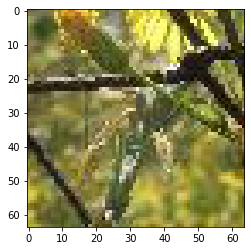

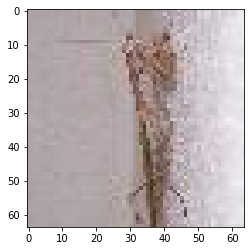

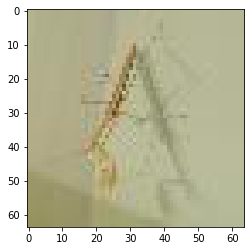

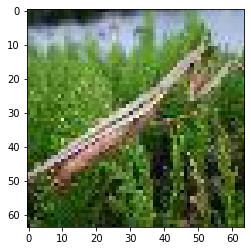

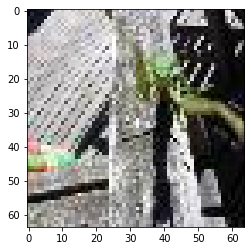

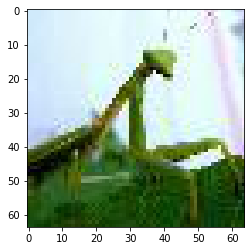

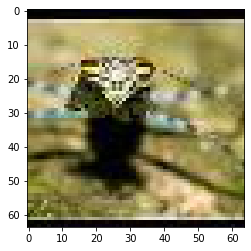

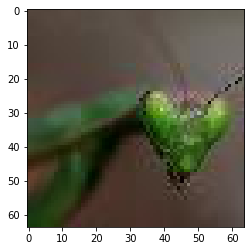

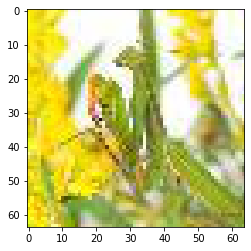

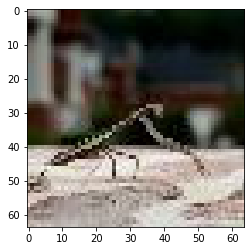

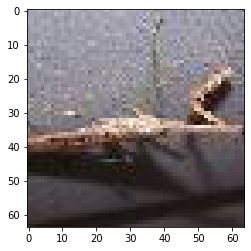

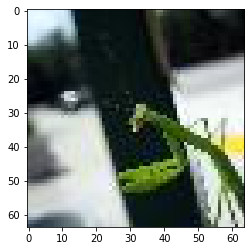

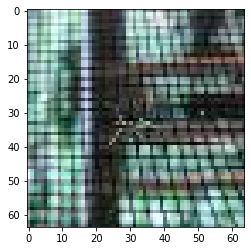

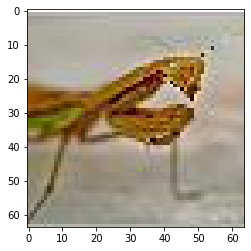

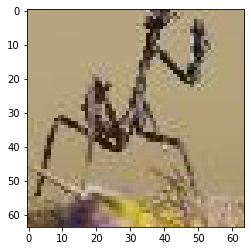

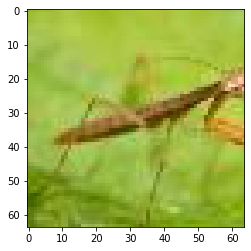

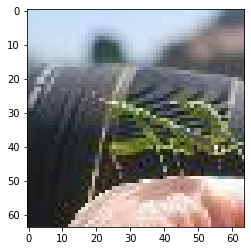

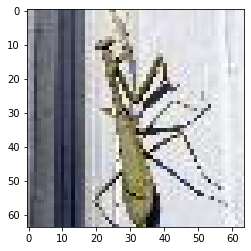

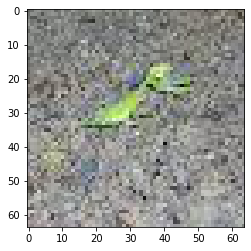

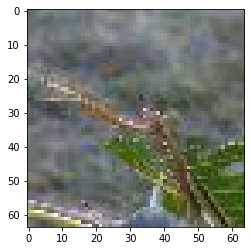

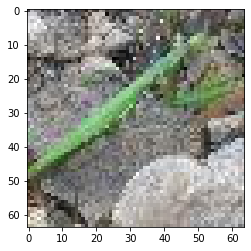

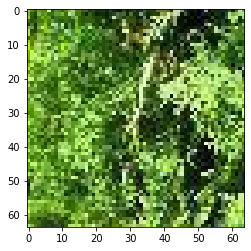

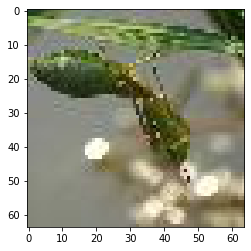

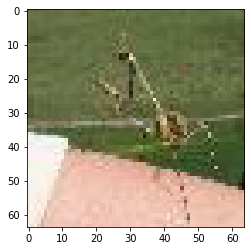

KeyboardInterrupt: 

In [49]:
for img_path in glob.glob('./data/train/51/*'):
    plt.imshow(Image.open(img_path))
    plt.show()

In [ ]:
import torch

In [ ]:
from torch.utils.data import TensorDataset, Dataset
from torch.utils.data import DataLoader
from torchvision import transforms

In [ ]:
class MyDataset(Dataset):
    def __init__(self, data, targets, transform=None):
        self.data = data
        self.targets = torch.LongTensor(targets)
        self.transform = transform

    def __getitem__(self, index):
        x = self.data[index]
        y = self.targets[index]

        if self.transform:
            x = self.transform(x)

        return x, y

    def __len__(self):
        return len(self.data)

In [ ]:
def get_transforms():
    
    mean=[0.485, 0.456, 0.406]
    std=[0.229, 0.224, 0.225]

    train_transforms = transforms.Compose([transforms.ToPILImage(),
                                                        transforms.RandomHorizontalFlip(),
                                                        transforms.ToTensor(),
                                                        transforms.Normalize(mean, std),
                                                        transforms.RandomErasing()])
    test_transforms = transforms.Compose([transforms.ToPILImage(),transforms.ToTensor(), 
                                                        transforms.Normalize(mean, std)])

    return train_transforms, test_transforms

In [ ]:
train_transforms, test_transforms = get_transforms()

In [ ]:
train_dataset = MyDataset(train_data, train_labels, transform=train_transforms)
test_dataset = MyDataset(test_data, test_labels, transform=test_transforms)

In [ ]:
train_loader = DataLoader(train_dataset, shuffle=True, batch_size=64)
test_loader = DataLoader(test_dataset, shuffle=False, batch_size=32)

In [ ]:
it = iter(train_loader)

In [ ]:
images, labels = it.next()

In [ ]:
def denormalize(tensor, mean, std):
    if not tensor.ndimension() == 4:
        tensor = tensor.view(1, tensor.shape[0], tensor.shape[1], tensor.shape[2])

    mean = torch.FloatTensor(mean).view(1, 3, 1, 1).expand_as(tensor).to(tensor.device)
    std = torch.FloatTensor(std).view(1, 3, 1, 1).expand_as(tensor).to(tensor.device)

    return tensor.mul(std).add(mean).squeeze()

def display_images(images, labels):
        
    mean=[0.485, 0.456, 0.406]
    std=[0.229, 0.224, 0.225]
    
    fig, axs = plt.subplots(4, 8, figsize=(15, 10))
    for i in range(32):
        r = int(i / 8)
        c = int(i % 8)
        label = labels[i]
        img = images[i]
        img = denormalize(img, mean, std)
        np_img = img.numpy().transpose(1, 2, 0)
        axs[r, c].imshow(np_img)
    plt.show()

In [ ]:
images.size()

In [ ]:
display_images(images, labels)

In [ ]:
from Modules.data import cifiar_data_loader
from Modules.models.custom_cifar_network import Net

#from Modules.models.torchvision_resnet import Net

from Modules.train.train_eval import train, test
from Modules.utility import visulization
from Modules.grad_cam.gradcam import GradCAM, GradCAMpp
from Modules.grad_cam.utility import visualize_cam

In [ ]:
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
print(device)
model = Net(num_classes=200).to(device)
summary(model, input_size=(3, 32, 32))

In [ ]:
optimizer = torch.optim.SGD(model.parameters(), lr = 0.01, momentum=0.9)

In [ ]:

from tqdm import tqdm

import torch
import torch.nn.functional as F

def train(model, device, trainloader, optimizer, i, train_losses, train_acc):
    model.train()
    pbar = tqdm(trainloader)
    for batch_idx, (data, target) in enumerate(pbar):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        pred = model(data)
        pred = F.log_softmax(pred, dim=-1) 
        #print(pred.size(), target.size())
        loss = F.nll_loss(pred, target)
        loss.backward()
        optimizer.step()
        pred = pred.argmax(dim=1, keepdim=True)
        correct = pred.eq(target.view_as(pred)).sum().item()
        total = len(data)
        train_losses.append(loss.item())
        train_acc.append(correct/ total)
        pbar.set_description(desc=f'{i} loss : {loss.item()} acc : {correct/ total}')
        
def test(model, device, test_loader, test_losses, test_acc):
    model.eval()
    correct_agg = 0
    total_agg = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            pred = model(data)
            loss = F.nll_loss(pred, target)
            pred = pred.argmax(dim=1, keepdim=True)
            correct = pred.eq(target.view_as(pred)).sum().item()
            total = len(data)
            total_agg += total
            correct_agg += correct
            test_losses.append(loss.item())
            test_acc.append(correct/ total)
        print('Acc : ', correct_agg / total_agg * 100.0)

In [ ]:
train_losses = []
test_losses = []
train_acc = []
test_acc = []

total_epochs = 50
for i in range(total_epochs):
    train(model, device, train_loader, optimizer, i, train_losses, train_acc)
    test(model, device, test_loader,  test_losses, test_acc)

In [ ]:
visulization.display_graphs(train_losses, test_losses, train_acc, test_acc)